In [1]:
import pandas as pd
import numpy as np  
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm" , disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
 


import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/triyuliannibasukie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseV

In [2]:
tweets = pd.read_csv('2022 Twitter Tweets Jan-April_Amber Heard Data.csv')
tweets

,id_str,created_at,full_text,lang,in_reply_to_status_id_str,in_reply_to_user_id,entities.hashtags,entities.media,entities.symbols,entities.urls,...,user.friends_count,user.lang,user.location,user.name,user.screen_name,user.profile_banner_url,user.profile_image_url,user.statuses_count,user.url,user.verified
0,1477504983130116096.0,2022-01-02 05:00:13+00:00,@la77465262 @Melinda15199317 @Dior So why is #...,en,1466075642244603909,1363630915298148352.0,"[{'indices': [45, 56], 'text': 'JohnnyDepp'}]","[{'original_info': {'width': 1058, 'focus_rect...",[],[],...,1898.0,NaN,NaN,Sean O'Connor,seano999,https://pbs.twimg.com/profile_banners/11497951...,http://pbs.twimg.com/profile_images/1442389537...,27033.0,NaN,False
1,1477503751716065280.0,2022-01-02 04:55:19+00:00,Only thing I want them to leave alone is the f...,en,NaN,NaN,[],NaN,[],[],...,1025.0,NaN,NaN,❤️‍🔥 Wilson the Opp Slayer 🔪,WonderWilson18,https://pbs.twimg.com/profile_banners/14262271...,http://pbs.twimg.com/profile_images/1515742990...,27853.0,https://t.co/dVvgQNht1k,False
2,1477499814719983616.0,2022-01-02 04:39:41+00:00,@soldierboy43001 @ZakReckless Yeah but Snyder ...,en,1477497121972621318,1297204830231040000.0,[],NaN,[],[],...,139.0,NaN,NaN,Steven Curry,StevenJCurry,https://pbs.twimg.com/profile_banners/14273589...,http://pbs.twimg.com/profile_images/1429534379...,199.0,NaN,False
3,1477497740498292736.0,2022-01-02 04:31:26+00:00,@IIMissMax @bg98021 @GerberKawasaki You forgot...,en,1477475212992073728,305017078.0,[],NaN,[],[],...,128.0,NaN,NaN,Vincent 1,Vincent72516869,NaN,http://pbs.twimg.com/profile_images/1354614785...,2313.0,NaN,False
4,1477496477484212224.0,2022-01-02 04:26:25+00:00,I never seen Aquaman nor will I because Amber ...,en,NaN,NaN,[],NaN,[],[],...,141.0,NaN,𝗡𝗢𝗧 𝗦𝗣𝗢𝗜𝗟𝗘𝗥 𝗙𝗥𝗘𝗘,𝐇𝐘𝐃𝐄,YoonJaysSimp,https://pbs.twimg.com/profile_banners/10769432...,http://pbs.twimg.com/profile_images/1516751870...,5423.0,https://t.co/XkBVR5FDCS,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508242,1515569901158600704,2022-04-17 05:56:37+00:00,Gender card pulled out. They are now spinning ...,en,NaN,NaN,[],NaN,[],[],...,201,NaN,NaN,ayyy nakoooo,GhelSandra,https://pbs.twimg.com/profile_banners/27013539...,http://pbs.twimg.com/profile_images/1402120521...,30280,https://t.co/KRDaAomcsU,False
508243,1515569890391961601,2022-04-17 05:56:34+00:00,Amber heard is a libra moon. Ive known a few l...,en,NaN,NaN,[],NaN,[],[],...,154,NaN,NaN,Jeli Bean,lilithrising_,https://pbs.twimg.com/profile_banners/14184202...,http://pbs.twimg.com/profile_images/1516523367...,7863,NaN,False
508244,1515569612686970883,2022-04-17 05:55:28+00:00,#JusticeForJohnnyDepp \n#JusticeForJohnnyDeppV...,und,NaN,NaN,"[{'indices': [0, 21], 'text': 'JusticeForJohnn...",NaN,[],[],...,647,NaN,"Colorado, USA",Cindy Moss🌱Ⓥ,CJMoss007,NaN,http://pbs.twimg.com/profile_images/1502775880...,6225,NaN,False
508245,1515569604818575368,2022-04-17 05:55:26+00:00,"Amber Heard is dating Eve Fartlow, Chelsea Man...",en,NaN,NaN,[],NaN,[],[],...,3214,NaN,"Rockford, Illinois",Jalopy Galopy,Jankem69420,https://pbs.twimg.com/profile_banners/13194711...,http://pbs.twimg.com/profile_images/1427306627...,9171,https://t.co/C6Pn7cxcss,False


In [3]:
df = tweets.filter(['full_text', 'lang', "created_at"], axis=1)
df1 = df[df["lang"] == "en"]
df_jan = df1[(df1['created_at'] > '2022-02-01') & (df1['created_at'] < '2022-03-01')]
df2 = df_jan.dropna()
df2.head()

,full_text,lang,created_at
18900,4. My vote for #Minamata\n#OscarsFanFavorite \...,en,2022-02-22 05:02:57+00:00
18901,3. My vote for #Minamata\n#OscarsFanFavorite \...,en,2022-02-22 05:02:15+00:00
18902,2. My vote for #Minamata\n#OscarsFanFavorite \...,en,2022-02-22 05:01:45+00:00
18903,1. My vote for #Minamata\n#OscarsFanFavorite \...,en,2022-02-22 05:00:44+00:00
18908,Amber heard should go to jail and stop being c...,en,2022-02-22 04:15:11+00:00


# Data cleaning

In [4]:
# Remove non-English words

# remove hashtags 
df2['clean_text']  = df2['full_text'].map(lambda x: re.sub("#[A-Za-z0-9_]+", " ", str(x)))

# remove mentions
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("@[A-Za-z0-9_]+"," ", str(x)))

# remove links
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub(r"http\S+"," ", str(x)))

# remove "&amp"
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("&amp"," ", str(x)))

# remove punc 
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))

# lower case
df2['clean_text']  = df2['clean_text'].apply(lambda x: x.lower())

# remove amber heard and johnny depp
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("amber","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("heard","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("johnny","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("depp","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("ah","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("jd","", str(x)))

# tokenize
df2['clean_text']  = [word_tokenize(row) for row in df2['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df2['clean_text']  = df2['clean_text'].apply(lambda x: remove_stopwords(x))

In [5]:
df2.head()

,full_text,lang,created_at,clean_text
18900,4. My vote for #Minamata\n#OscarsFanFavorite \...,en,2022-02-22 05:02:57+00:00,"[4, vote]"
18901,3. My vote for #Minamata\n#OscarsFanFavorite \...,en,2022-02-22 05:02:15+00:00,"[3, vote]"
18902,2. My vote for #Minamata\n#OscarsFanFavorite \...,en,2022-02-22 05:01:45+00:00,"[2, vote]"
18903,1. My vote for #Minamata\n#OscarsFanFavorite \...,en,2022-02-22 05:00:44+00:00,"[1, vote]"
18908,Amber heard should go to jail and stop being c...,en,2022-02-22 04:15:11+00:00,"[go, jail, stop, cast, movies, abusers, go, ja..."


In [6]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df2['clean_text'] = df2['clean_text'].apply(lambda x: lemmatization(x))


df2.head()

,full_text,lang,created_at,clean_text
18900,4. My vote for #Minamata\n#OscarsFanFavorite \...,en,2022-02-22 05:02:57+00:00,[vote]
18901,3. My vote for #Minamata\n#OscarsFanFavorite \...,en,2022-02-22 05:02:15+00:00,[vote]
18902,2. My vote for #Minamata\n#OscarsFanFavorite \...,en,2022-02-22 05:01:45+00:00,[vote]
18903,1. My vote for #Minamata\n#OscarsFanFavorite \...,en,2022-02-22 05:00:44+00:00,[vote]
18908,Amber heard should go to jail and stop being c...,en,2022-02-22 04:15:11+00:00,"[jail, stop, movie, abuser, jail, pay, check]"


In [7]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df2['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '


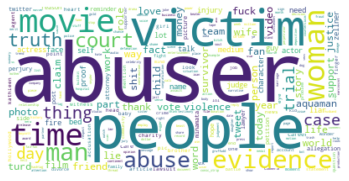

In [8]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("unigram_wordcloud_after.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

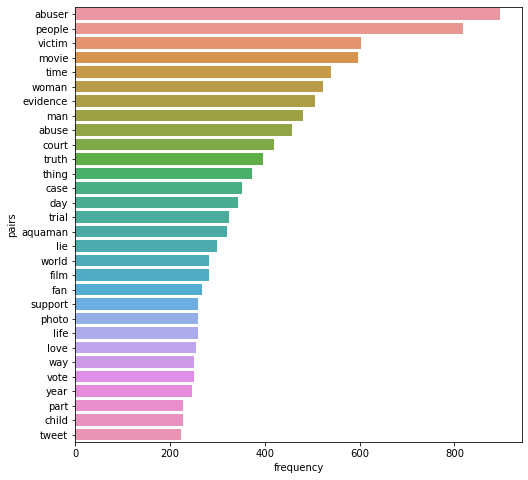

In [9]:
new_tokens = []
for i in df2["clean_text"].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

# Topic Modeling for Text


## Create Corpus 

In [10]:
data_lemmatized = df2['clean_text'].tolist()
print(data_lemmatized[:3])

[['vote'], ['vote'], ['vote']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'vote'), (1, 'abuser'), (2, 'check'), (3, 'jail'), (4, 'movie'), (5, 'pay'), (6, 'stop'), (7, 'body'), (8, 'person'), (9, 'shame'), (10, 'matter'), (11, 'opinion'), (12, 'reminder'), (13, 'man'), (14, 'people'), (15, 'headbutt'), (16, 'time'), (17, 'trial'), (18, 'year'), (19, 'evidence'), (20, 'part'), (21, 'punishment'), (22, 'woman'), (23, 'canne'), (24, 'dinner'), (25, 'filmmaker'), (26, 'narrative'), (27, 'copy'), (28, 'noise'), (29, 'paste'), (30, 'voice'), (31, 'comment'), (32, 'rt'), (33, 'bunch'), (34, 'survivor'), (35, 'term'), (36, 'eye'), (37, 'relief'), (38, 'aquaman'), (39, 'firing'), (40, 'role'), (41, 'grindelwald'), (42, 'fan'), (43, 'psycho'), (44, 'injustice'), (45, 'hashtag'), (46, 'lot'), (47, 'show'), (48, 'support'), (49, 'twitter')]

Total Vocabulary Size: 2675


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [13]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [14]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.3509788320536018
Perplexity Score:  -6.822162160818607

topic number:  3
Coherence Score:  0.4034424709692666
Perplexity Score:  -6.914353913755051

topic number:  4
Coherence Score:  0.3225332578805652
Perplexity Score:  -6.9840363585324985

topic number:  5
Coherence Score:  0.32390879481660806
Perplexity Score:  -7.006076391763228

topic number:  6
Coherence Score:  0.35083066723024986
Perplexity Score:  -7.028259825389885

topic number:  7
Coherence Score:  0.3600591929612209
Perplexity Score:  -7.072799372916192

topic number:  8
Coherence Score:  0.37433125470513695
Perplexity Score:  -7.094138970628467

topic number:  9
Coherence Score:  0.33855821327267194
Perplexity Score:  -7.105504729568743

topic number:  10
Coherence Score:  0.3989574074688223
Perplexity Score:  -7.110416710036814

topic number:  11
Coherence Score:  0.40555503083668093
Perplexity Score:  -7.166522649518746

topic number:  12
Coherence Score:  0.4076805473457597
Perplex

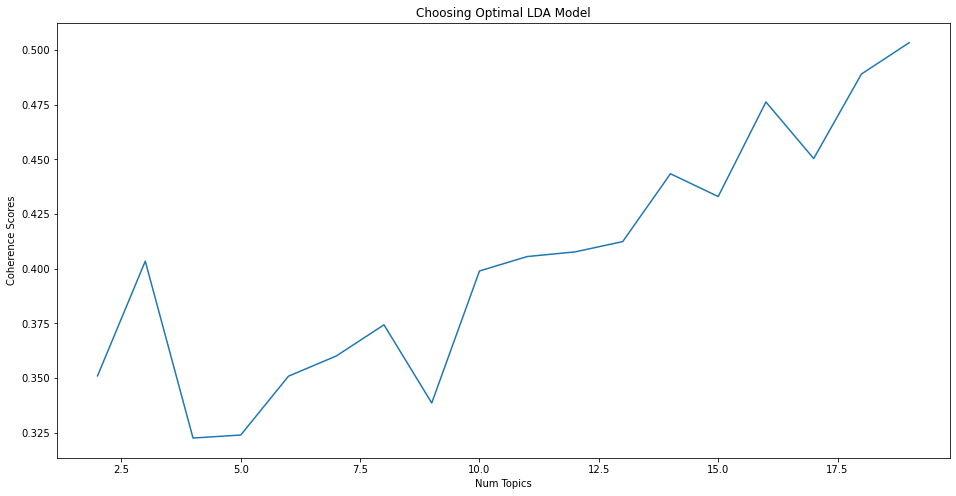

In [15]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [26]:
ntopics_des_name = 3

# We choose 3 because it has the highest coherence score reached before a major drop.

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [27]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.051*"abuser" + 0.036*"victim" + 0.032*"people" + 0.028*"evidence" + '
  '0.027*"abuse" + 0.022*"thing" + 0.022*"truth" + 0.018*"lie" + 0.014*"trial" '
  '+ 0.014*"photo"'),
 (1,
  '0.024*"day" + 0.020*"vote" + 0.019*"love" + 0.017*"child" + 0.016*"tweet" + '
  '0.013*"wife" + 0.012*"money" + 0.011*"support" + 0.010*"movie" + '
  '0.010*"thank"'),
 (2,
  '0.035*"woman" + 0.034*"time" + 0.031*"man" + 0.030*"movie" + 0.025*"court" '
  '+ 0.019*"aquaman" + 0.018*"world" + 0.016*"life" + 0.015*"people" + '
  '0.013*"friend"')]


In [28]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [29]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df2)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [30]:
df2['Topic'] = topic_num

In [31]:
des_name_final = df2[['full_text', 'clean_text', 'Topic']]
des_name_final.head()

,full_text,clean_text,Topic
18900,4. My vote for #Minamata\n#OscarsFanFavorite \...,[vote],"[1, 2, 0]"
18901,3. My vote for #Minamata\n#OscarsFanFavorite \...,[vote],"[1, 2, 0]"
18902,2. My vote for #Minamata\n#OscarsFanFavorite \...,[vote],"[1, 2, 0]"
18903,1. My vote for #Minamata\n#OscarsFanFavorite \...,[vote],"[1, 2, 0]"
18908,Amber heard should go to jail and stop being c...,"[jail, stop, movie, abuser, jail, pay, check]","[0, 2, 1]"


### Model Evaluation

In [32]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -6.914159550421317
Coherence Score:  0.33709119575821817


## Visualisation

In [33]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.147427  0.250196       1        1  36.431502
2     -0.151756 -0.247794       2        1  33.198671
1      0.299183 -0.002401       3        1  30.369827, topic_info=        Term        Freq       Total Category  logprob  loglift
1     abuser  869.000000  869.000000  Default  30.0000  30.0000
88    victim  592.000000  592.000000  Default  29.0000  29.0000
22     woman  515.000000  515.000000  Default  28.0000  28.0000
16      time  511.000000  511.000000  Default  27.0000  27.0000
13       man  462.000000  462.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
346     face   95.151385  113.789500   Topic3  -4.9615   1.0128
108      bed   98.607234  122.346110   Topic3  -4.9258   0.9760
48   support  149.694971  253.514417   Topic3  -4.5083   0.6649
4      movie  141.719086  586.048400   Topic3  -4.5631  -0.2278
42       fan  108.098304  272.207616   Topic3  -4.8339   0.2682

[155 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
118       1  0.997707       abuse
1         1  0.953152      abuser
1         3  0.045990      abuser
145       2  0.985926  accusation
237       2  0.997386       actor
...     ...       ...         ...
100       3  0.167212        work
101       2  0.996045       world
18        2  0.700902        year
18        3  0.297988        year
903       3  0.986558     zellner

[157 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

## Word Count of Topic Keywords

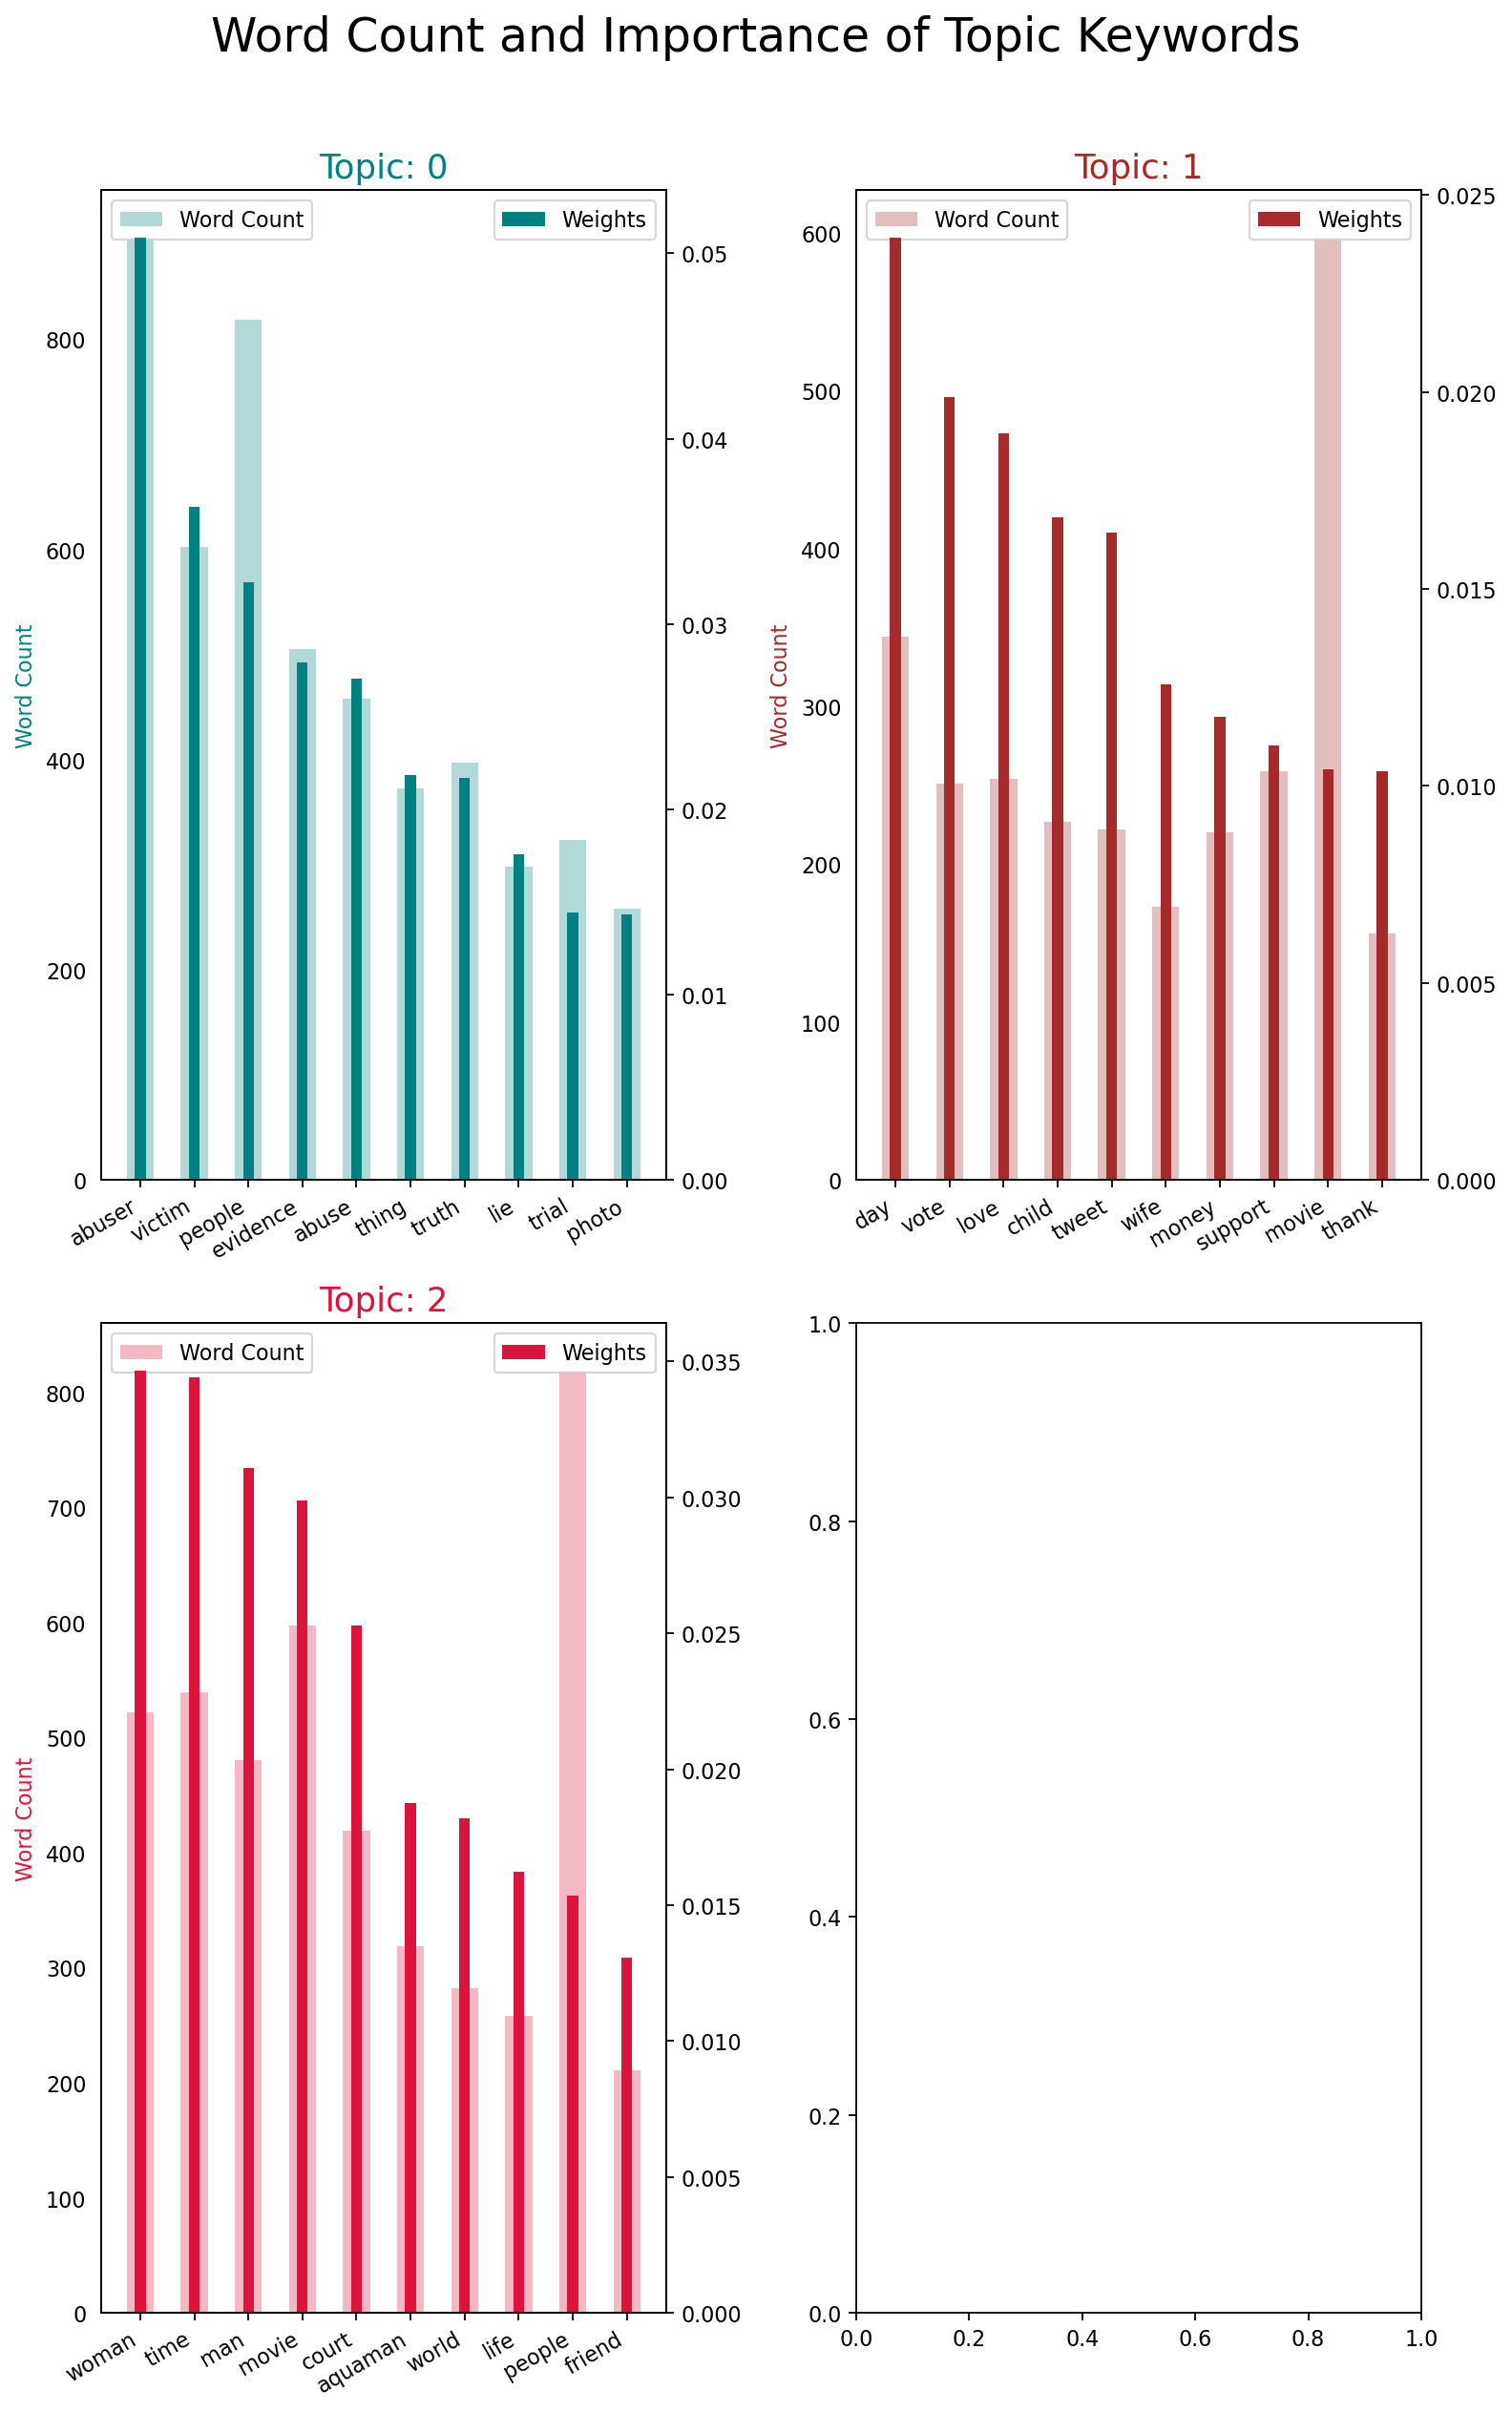

In [35]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('unigram_lda_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()
